# Project 2: What kind of wine is this?

## David Apostol

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

# 1.

## Load and preprocess data

In [2]:
train = pd.read_parquet(
    "s3://ling583/wine-train.parquet", storage_options={"anon": True}
)
test = pd.read_parquet("s3://ling583/wine-test.parquet", storage_options={"anon": True})

In [3]:
train.head()

,review_text,wine_variant
0,Rich smoky dark cherry nose very intense fruit...,Pinot Noir
1,Had this at Corton Restaurant in NYC. First of...,Syrah
2,"Nose is very tart, with a layer of sweet fruit...",Pinot Noir
3,Beautiful golden color. Discrete perfumed nose...,Chardonnay
4,Please take the time to decant: you will not b...,Pinot Noir


In [4]:
train["wine_variant"].value_counts()

Pinot Noir            38471
Cabernet Sauvignon    30234
Chardonnay            19443
Syrah                 13704
Riesling               9683
Zinfandel              8327
Merlot                 5522
Sauvignon Blanc        5113
Name: wine_variant, dtype: int64

In [5]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if t.is_alpha]

In [6]:
import multiprocessing as mp

In [7]:
with mp.Pool() as p:
    train["tokens"] = pd.Series(p.imap(tokenize, tqdm(train["review_text"]), chunksize=100))
    test["tokens"] = pd.Series(p.imap(tokenize, tqdm(test["review_text"]), chunksize=100))

  0%|          | 0/130497 [00:00<?, ?it/s]

  0%|          | 0/32625 [00:00<?, ?it/s]

In [8]:
train.head()

,review_text,wine_variant,tokens
0,Rich smoky dark cherry nose very intense fruit...,Pinot Noir,"[rich, smoky, dark, cherry, nose, very, intens..."
1,Had this at Corton Restaurant in NYC. First of...,Syrah,"[had, this, at, corton, restaurant, in, nyc, f..."
2,"Nose is very tart, with a layer of sweet fruit...",Pinot Noir,"[nose, is, very, tart, with, a, layer, of, swe..."
3,Beautiful golden color. Discrete perfumed nose...,Chardonnay,"[beautiful, golden, color, discrete, perfumed,..."
4,Please take the time to decant: you will not b...,Pinot Noir,"[please, take, the, time, to, decant, you, wil..."


## SGD Classifier

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

In [10]:
sgd = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
sgd.fit(train["tokens"], train["wine_variant"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.67      0.84      0.74      7558
        Chardonnay       0.77      0.88      0.82      4861
            Merlot       0.77      0.35      0.48      1381
        Pinot Noir       0.81      0.83      0.82      9618
          Riesling       0.86      0.74      0.79      2421
   Sauvignon Blanc       0.81      0.66      0.73      1278
             Syrah       0.71      0.56      0.63      3426
         Zinfandel       0.87      0.51      0.65      2082

          accuracy                           0.76     32625
         macro avg       0.78      0.67      0.71     32625
      weighted avg       0.77      0.76      0.75     32625



In [11]:
import logger
import mlflow
from logger import log_search, log_test

In [12]:
mlflow.set_experiment("project_2")
log_test(sgd, test["wine_variant"], predicted)

## Hyperparameters

In [13]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36739")
client

Client Scheduler: tcp://127.0.0.1:36739 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.62 GB


In [14]:
from dask_ml.model_selection import RandomizedSearchCV
from scipy.stats.distributions import loguniform, randint, uniform

In [15]:
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

In [16]:
mlflow.set_experiment("project_2/SGDClassifier")

In [17]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "sgdclassifier__alpha": loguniform(1e-5, 2),
    },
    n_iter=25,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["wine_variant"])
log_search(search)

CPU times: user 12.4 s, sys: 1.45 s, total: 13.8 s
Wall time: 4min 11s


## Optimized Model for SGD Classifier

In [39]:
sgd = make_pipeline(
    CountVectorizer(analyzer=identity, min_df=2, max_df=0.5234), SGDClassifier(alpha=1.9e-4)
)
sgd.fit(train["tokens"], train["wine_variant"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.70      0.80      0.75      7558
        Chardonnay       0.79      0.86      0.83      4861
            Merlot       0.82      0.34      0.48      1381
        Pinot Noir       0.78      0.85      0.81      9618
          Riesling       0.80      0.78      0.79      2421
   Sauvignon Blanc       0.84      0.66      0.74      1278
             Syrah       0.69      0.57      0.62      3426
         Zinfandel       0.77      0.55      0.64      2082

          accuracy                           0.76     32625
         macro avg       0.78      0.68      0.71     32625
      weighted avg       0.76      0.76      0.75     32625



## Passive Aggressive Classifier

In [19]:
from sklearn.linear_model import PassiveAggressiveClassifier 

In [20]:
passagg = make_pipeline(CountVectorizer(analyzer=identity), PassiveAggressiveClassifier())
passagg.fit(train["tokens"], train["wine_variant"])
predicted = passagg.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted)) 

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.62      0.80      0.70      7558
        Chardonnay       0.85      0.75      0.80      4861
            Merlot       0.42      0.35      0.38      1381
        Pinot Noir       0.85      0.70      0.77      9618
          Riesling       0.69      0.81      0.75      2421
   Sauvignon Blanc       0.67      0.68      0.68      1278
             Syrah       0.71      0.45      0.55      3426
         Zinfandel       0.42      0.65      0.51      2082

          accuracy                           0.69     32625
         macro avg       0.65      0.65      0.64     32625
      weighted avg       0.72      0.69      0.70     32625



## TfidTransformer Classifier

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer 

In [22]:
tfid = make_pipeline(CountVectorizer(analyzer=identity), 
                    TfidfTransformer(), 
                    SGDClassifier())
tfid.fit(train["tokens"], train["wine_variant"])
predicted = tfid.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted)) 

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.69      0.81      0.75      7558
        Chardonnay       0.78      0.87      0.82      4861
            Merlot       0.87      0.32      0.47      1381
        Pinot Noir       0.73      0.89      0.80      9618
          Riesling       0.83      0.71      0.76      2421
   Sauvignon Blanc       0.85      0.62      0.72      1278
             Syrah       0.79      0.48      0.60      3426
         Zinfandel       0.90      0.48      0.62      2082

          accuracy                           0.75     32625
         macro avg       0.80      0.65      0.69     32625
      weighted avg       0.76      0.75      0.74     32625



Based on the three classifiers I tried, SGD seems to be the best performing as it has the highest f1-scores out of the three.

# 2.

## Predicting Tools Using Labels

In [23]:
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

In [24]:
explainer = LimeTextExplainer(class_names=sgd.named_steps['sgdclassifier'].classes_)

In [61]:
exp = explainer.explain_instance(
    test["review_text"].loc[1613], sgd.decision_function, num_features=15, labels=[0, 1, 2, 3]
)

[]

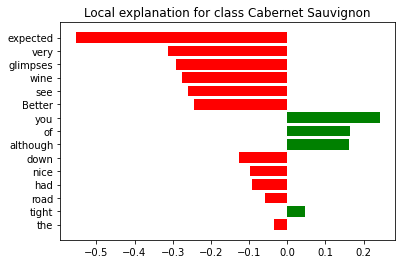

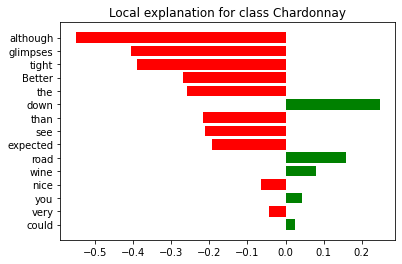

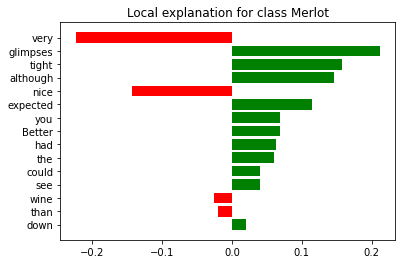

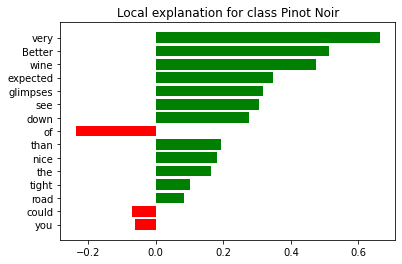

In [62]:
for i in range(0, 4):
    exp.as_pyplot_figure(i)
plt.plot()

The aspect that the review texts are most sensitive to are descriptive words as these are core in describing wine quality and taste notes.

Based on the charts, there is evidence of overfitting particularly with the word "road" as it probably has almost nothing to do with the wines themselves but rather referring to how they would be good to take home.

# 3.

## Decision Function

In [31]:
import cloudpickle
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

In [47]:
scores = sgd.decision_function(test["review_text"]) 

In [48]:
margin = scores[:,3]-scores[:,2] 

In [49]:
margin.max(), margin.min()

(118.99213738524386, -0.06355110792878571)

In [50]:
print(classification_report(test["wine_variant"][margin > 5], predicted[margin > 5]))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.74      0.81      0.78      5014
        Chardonnay       0.83      0.88      0.85      2997
            Merlot       0.80      0.37      0.51       851
        Pinot Noir       0.82      0.88      0.85      6796
          Riesling       0.82      0.83      0.82      1636
   Sauvignon Blanc       0.84      0.68      0.75       740
             Syrah       0.72      0.62      0.66      2376
         Zinfandel       0.76      0.61      0.68      1262

          accuracy                           0.79     21672
         macro avg       0.79      0.71      0.74     21672
      weighted avg       0.79      0.79      0.78     21672



Text(0, 0.5, 'F1')

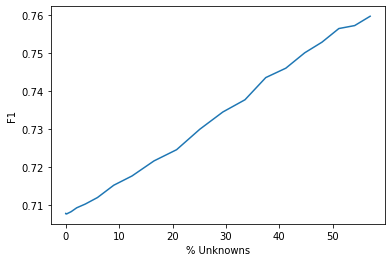

In [55]:
thresh = np.linspace(-7, 7, 50)
x = [100*(1-sum(margin > t)/len(margin)) for t in thresh]
y = [f1_score(test["wine_variant"][margin > t], predicted[margin > t], average="macro") for t in thresh]
plt.plot(x, y)
plt.xlabel('% Unknowns')
plt.ylabel('F1') 

In order to get a f1-score higher than .85, we would to exclude pretty much everything. We don't want to exclude too much though and so this method is not good.

# 4.

## Confusion Matrix

In [40]:
cloudpickle.dump(sgd, open("sgd.model", "wb"))

In [41]:
sgd = cloudpickle.load(open("sgd.model", "rb"))

In [42]:
sgd

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x7fb5deaf12b0>,
                                 max_df=0.5234, min_df=2)),
                ('sgdclassifier', SGDClassifier(alpha=0.00019))])

In [43]:
predicted = sgd.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.70      0.80      0.75      7558
        Chardonnay       0.79      0.86      0.83      4861
            Merlot       0.82      0.34      0.48      1381
        Pinot Noir       0.78      0.85      0.81      9618
          Riesling       0.80      0.78      0.79      2421
   Sauvignon Blanc       0.84      0.66      0.74      1278
             Syrah       0.69      0.57      0.62      3426
         Zinfandel       0.77      0.55      0.64      2082

          accuracy                           0.76     32625
         macro avg       0.78      0.68      0.71     32625
      weighted avg       0.76      0.76      0.75     32625



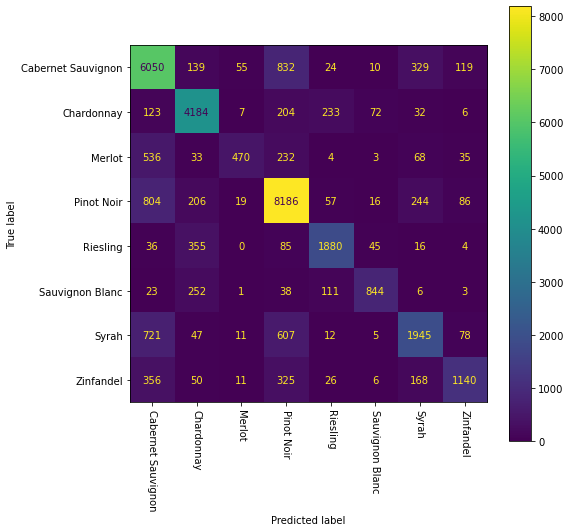

In [75]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sgd, test["tokens"], test["wine_variant"], xticks_rotation=-90, ax=ax)

## Creating New Labels by Combining Labels

In [112]:
train_copy = train.copy()

In [113]:
m = train_copy['wine_variant'].isin(['Cabernet Sauvignon', 'Pinot Noir'])
train_copy['wine_variant'] = train_copy['wine_variant'].mask(m, 'Cabernet Sauvignon/Pinot Noir')
m = train_copy['wine_variant'].isin(['Chardonnay', 'Riesling'])
train_copy['wine_variant'] = train_copy['wine_variant'].mask(m, 'Chardonnay/Riesling')
m = train_copy['wine_variant'].isin(['Syrah', 'Zinfandel'])
train_copy['wine_variant'] = train_copy['wine_variant'].mask(m, 'Syrah/Zinfandel')
m = train_copy['wine_variant'].isin(['Merlot', 'Sauvignon Blanc'])
train_copy['wine_variant'] = train_copy['wine_variant'].mask(m, 'Merlot/Sauvignon Blanc')

In [103]:
test_copy = test.copy()

In [104]:
m = test_copy['wine_variant'].isin(['Cabernet Sauvignon', 'Pinot Noir'])
test_copy['wine_variant'] = test_copy['wine_variant'].mask(m, 'Cabernet Sauvignon/Pinot Noir')
m = test_copy['wine_variant'].isin(['Chardonnay', 'Riesling'])
test_copy['wine_variant'] = test_copy['wine_variant'].mask(m, 'Chardonnay/Riesling')
m = test_copy['wine_variant'].isin(['Syrah', 'Zinfandel'])
test_copy['wine_variant'] = test_copy['wine_variant'].mask(m, 'Syrah/Zinfandel')
m = test_copy['wine_variant'].isin(['Merlot', 'Sauvignon Blanc'])
test_copy['wine_variant'] = test_copy['wine_variant'].mask(m, 'Merlot/Sauvignon Blanc')

## SGD Classifier on New Labels

In [114]:
sgd = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
sgd.fit(train_copy["tokens"], train_copy["wine_variant"])
predicted = sgd.predict(test_copy["tokens"])
print(classification_report(test_copy["wine_variant"], predicted))

                               precision    recall  f1-score   support

Cabernet Sauvignon/Pinot Noir       0.82      0.95      0.88     17176
          Chardonnay/Riesling       0.91      0.90      0.91      7282
       Merlot/Sauvignon Blanc       0.87      0.47      0.61      2659
              Syrah/Zinfandel       0.81      0.60      0.69      5508

                     accuracy                           0.84     32625
                    macro avg       0.85      0.73      0.77     32625
                 weighted avg       0.84      0.84      0.83     32625



We create new labels based on which wines are cosistently confused for one another. However,  after Cabernet Sauvignon/Pinot Noir and Chardonnay/Riesling,  the remaining wines are not really confused for one another. We are able to increase the f1-score from our initial .71 to .77 but no, it is not possible to get the f1-score at or above .85 after using the classifier on a new set of combined labels. 